<a href="https://colab.research.google.com/github/felipeserna/holbertonschool-machine_learning/blob/master/supervised_learning/0x0E-time_series/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                Timestamp    Close
0     2017-01-01 00:58:00   970.27
1     2017-01-01 02:16:00   971.34
2     2017-01-01 03:16:00   969.28
3     2017-01-01 04:18:00   968.11
4     2017-01-01 05:19:00   966.29
...                   ...      ...
17471 2019-01-07 17:56:00  4018.69
17472 2019-01-07 18:56:00  4016.85
17473 2019-01-07 19:56:00  4023.00
17474 2019-01-07 20:56:00  4007.00
17475 2019-01-07 21:56:00  4009.54

[17476 rows x 2 columns]
         count       mean         std  ...      50%        75%       max
Close  17476.0  5774.6824  3723.88566  ...  6209.43  7659.9925  19864.99

[1 rows x 8 columns]
Epoch 1/20
509/509 [==============================] - 9s 14ms/step - loss: 0.2259 - mean_absolute_error: 0.2512 - val_loss: 3.4332e-04 - val_mean_absolute_error: 0.0125
Epoch 2/20
509/509 [==============================] - 6s 13ms/step - loss: 0.0018 - mean_absolute_error: 0.0233 - val_loss: 2.8538e-04 - val_mean_absolute_error: 0.0102
Epoch 3/20
509/509 [============================

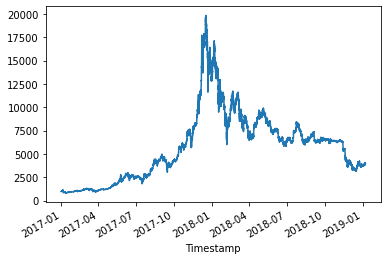

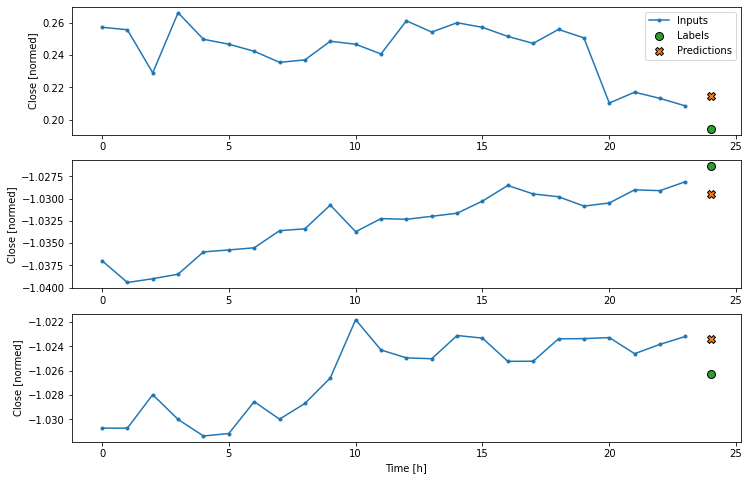

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


def preprocess_raw_data():
    """
    Returns: train_df, val_df, test_df
    """
    # making data frame from csv file
    data = \
        pd.read_csv('/content/drive/MyDrive/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')

    data = data.drop(["Open", "High", "Low", "Volume_(BTC)",
                     "Volume_(Currency)", "Weighted_Price"], axis=1)

    df = data.dropna()

    df = df[0::60]

    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df.reset_index(inplace=True, drop=True)

    df = df[df['Timestamp'].dt.year >= 2017]
    df.reset_index(inplace=True, drop=True)

    print(df)

    print(df.describe().transpose())

    date_time = pd.to_datetime(df.pop('Timestamp'), format='%Y-%m-%d %H:%M:%S')
    # print(df)
    plot_features = df['Close']
    plot_features.index = date_time
    _ = plot_features.plot(subplots=True)

    column_indices = {name: i for i, name in enumerate(df.columns)}

    # Split the data
    # Training 70%, validation 20%, test 10%
    n = len(df)
    train_df = df[0:int(n * 0.7)]
    val_df = df[int(n * 0.7):int(n * 0.9)]
    test_df = df[int(n * 0.9):]

    # Normalize the data
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    return train_df, val_df, test_df


class WindowGenerator:
    """
    Data windowing
    """
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        """
        Class constructor
        shift = offset
        """
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices
        self.label_columns = label_columns

        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = \
            np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = \
            np.arange(self.total_window_size)[self.labels_slice]
    

    def split_window(self, features):
        """
        Returns: inputs, labels
        """
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]]
                 for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Close', max_subplots=3):
        """
        Returns: nothing
        """
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        # labels = labels*3723.88566 + 5774.6824
        # inputs = inputs*3723.88566 + 5774.6824

        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col,
                                                                 None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                # tf.expand_dims(predictions, -1)
                # checking shapes
                # print("check_1", labels.shape)
                # print("check_2", predictions.shape)
                plt.scatter(self.label_indices,
                            predictions[n, 0],
                            marker='X', edgecolors='k',
                            label='Predictions',
                            c='#ff7f0e', s=64)
                # labels[n, :, label_col_index]
                # predictions[n, 0]*3723.88566 + 5774.6824
                # below it works
                # self.label_indices
                # predictions[n, 0],

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        """
        Creates tf.data.Datasets
        Returns: ds
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=24,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result


def compile_and_fit(model, window, patience=2, epochs=20):
    """
    Returns: history
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history


def forecasting(train, validation, test):
    """
    Returns: nothing
    """
    window = WindowGenerator(input_width=24, label_width=1, shift=1,
                             train_df=train, val_df=validation, test_df=test,
                             label_columns=['Close'])
        
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(24, return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)])

    # Train the model and evaluate its performance
    history = compile_and_fit(lstm_model, window)

    val_performance = {}
    performance = {}
    val_performance['LSTM'] = lstm_model.evaluate(window.val)
    performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)

    window.plot(lstm_model)


# here goes the main file
    
train, validation, test = preprocess_raw_data()

forecasting(train, validation, test)